## Imports

In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IN_PATH = ".\inputs"
OUT_PATH = ".\outputs"

## Utility Functions

In [3]:
def find_dependence(graph, graph2, is_ancestor, evidence, node1, node2):
    path = [[node1, True]]
    dependent_nodes = [False] * len(graph)
    visited = [False] * (2 * len(graph))
    while len(path) != 0:
        node, direction = path.pop()
        if direction:
            visited_index = node + len(graph)
        else:
            visited_index = node
        if not visited[visited_index]:
            visited[visited_index] = True
            if evidence[node] == -1:
                dependent_nodes[node] = True
            else:
                dependent_nodes[node] = False
            if direction and evidence[node] == -1:
                for k in graph2[node]:
                    path.append([k, True])
                for k in graph[node]:
                    path.append([k, False])
            if not direction:
                if evidence[node] == -1:
                    for k in graph[node]:
                        path.append([k, False])
                if is_ancestor[node]:
                    for k in graph2[node]:
                        path.append([k, True])
    return dependent_nodes[node2]

In [4]:
def mult(cpt1, cpt2):
    cpt = []
    keys1 = cpt1[0].keys()
    keys2 = cpt2[0].keys()
    share_keys = []
    not_share_keys = []
    for key in keys1:
        if key in keys2 and key != 'Prob':
            share_keys.append(key)
        else:
            not_share_keys.append(key)
    for row1 in cpt1:
        for row2 in cpt2:
            flag = 1
            for key in share_keys:
                if row1[key] != row2[key]:
                    flag = 0
            if flag == 0:
                continue
            new_row = row2.copy()
            for key in not_share_keys:
                if key != 'Prob':
                    new_row[key] = row1[key]
                else:
                    new_row['Prob'] = row1['Prob'] * row2['Prob']
            cpt.append(new_row)
    return cpt

In [5]:
def find_joint(probability):
    cpt = probability[0]
    for i in range(1, len(probability)):
        cpt = mult(cpt, probability[i])
    return cpt

In [6]:
def elimination(joint, node):
    del_cpt = []
    id_tracker = {}
    for row2 in joint:
        row = row2.copy()
        id_string = ""
        for key in row.keys():
            if key == node or key == "Prob":
                continue
            if row[key]:
                id_string += "T"
            else:
                id_string += "F"
        if id_string in id_tracker.keys():
            id_tracker[id_string]['Prob'] += row['Prob']
        else:
            id_tracker[id_string] = row
    for key in id_tracker.keys():
        row = id_tracker[key]
        del row[node]
        del_cpt.append(row.copy())
    return del_cpt

In [16]:
def variable_elimination(evidence, nodes, probability, values):
    new_probability = probability
    for i in range(len(probability)):
        if i in nodes or evidence[i] != -1:
            continue
        after_joint_prob = []
        joint_prob = []
        for cpt in new_probability:
            if i in cpt[0].keys():
                joint_prob.append(cpt)
            else:
                after_joint_prob.append(cpt)
        joint = find_joint(joint_prob)
        new_probability = after_joint_prob
        new_probability.append(elimination(joint, i))
    final_joint = find_joint(new_probability)
    sum_prob = 0
    holder = 0
    for joint in final_joint:
        sum_prob += joint['Prob']
        flag = 1
        for k in range(len(nodes)):
            if joint[nodes[k]] != bool(values[k]):
                flag = 0
                break
        if flag == 1:
            holder = joint['Prob']
    return holder / sum_prob

In [7]:
def topological_sort_util(v, visited, stack, graph):
    visited[v] = True
    for i in graph[v]:
        if not visited[i]:
            topological_sort_util(i, visited, stack, graph)

    stack.append(v)

def topological_sort(graph):
    visited = [False] * len(graph)
    stack = []

    for i in range(len(graph)):
        if not visited[i]:
            topological_sort_util(i, visited, stack, graph)
    return stack[::-1] # reverse the stack

In [8]:
def sample_vertex(node, father, values, sort_vertex, probability):
    # node = vertex to be sampled
    # father = father of the vertex (parents)
    # values = sample
    # sort_vertex = topological sort of the graph
    # probability = probability of the graph (array of CPTs)
    cpt = probability[node]
    holder_row = {} # row of the CPT to be sampled that is consistent with the privious sampled values
    for row in cpt: # row = {0: True, Prob: 0.1, 1: True, 2: True}
        flag = 1
        for key in row.keys():
            if key != 'Prob' and values[key] != -1 and row[key] != values[key]: # this node has already been sampled (notice that parents are already sampled beacuse we are doing topological sort)
                flag = 0
                break
        if flag == 1: # this row is the one we want to sample (this row is consistent with the sampled values (parents)) # P(Xi | parents(Xi))
            holder_row = row.copy()
            break
    x = holder_row['Prob']
    random = np.random.random() # random number between 0 and 1
    if random < x: # sample the vertex ( [0,x): True , [x,1): False ]  )
        return True
    return False

In [9]:
def draw_plot(prior, reject, likelihood, gibbs, string_data, num):
    X = [1, 2, 3, 4, 5, 6, 7]
    # prior = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7] (array of prior absolute error)
    # reject (array of rejection absolute error)
    # likelihood (array of likelihood absolute error)
    # gibbs (array of gibbs absolute error)

    # Plotting both the curves simultaneously
    plt.plot(X, prior, color='r', label='Prior')
    plt.plot(X, reject, color='g', label='Rejection')
    plt.plot(X, likelihood, color='b', label='Likelihood')
    plt.plot(X, gibbs, color='y', label='Gibbs')

    plt.xlabel("#Q") # X-axis label (number of query)
    plt.ylabel("AE") # Y-axis label (absolute error)
    plt.title(string_data)
    plt.legend()
    path = OUT_PATH
    path = os.path.join(path, str(num) + ".png")
    plt.savefig(path)
    plt.show()

## Real Value

In [10]:
def real_value(evidence, probability, nodes, values, graph3):
    new_probability = []
    for i in range(len(probability)):
        cpt = []
        for row in probability[i]:
            if row[i] != evidence[i] and evidence[i] != -1:
                continue
            flag = 1
            for j in graph3[i]:
                if row[j] != evidence[j] and evidence[j] != -1:
                    flag = 0
            if flag:
                cpt.append(row)
        new_probability.append(cpt)
    return variable_elimination(evidence.copy(), nodes, new_probability.copy(), values)

## 1. Prior Sampling

In [11]:
def prior_sample(evidence, nodes, values, probability, n, graph, graph2):
    # evidence = array of bools (True/False) or -1 (unknown) for each node
    # nodes = array of nodes to query
    # values = array of bools (True/False) for each query node
    # probability = array of CPTs for each node
    # CPT = array of dicts (each dict is a row in the CPT) (CPT[0] = {2:True ,'Prob': 0.5, 0: True, 1: True})
    # n = number of nodes
    # graph = node --> children (graph1[0] = [1, 2])
    # graph2 = node --> parents (graph2[0] = [1, 2])
    
    sort_vertex = topological_sort(graph)
    samples = []
    for i in range(10000):
        value = [-1] * n # (sample) array of bools (True/False) or -1 (unknown) for each node (values of each node in sample)
        for vertex in sort_vertex: # in topological order
            value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability) # sample the vertex (value[vertex] = True/False)
        flag = 1
        for j in range(len(evidence)):
            if evidence[j] != -1 and value[j] != evidence[j]: # if evidence is known and not equal to sample (not consistent with evidence)
                flag = 0
                break
        if flag == 1: # if consistent with evidence 
            samples.append(value)
    good_sample = 0 # number of samples that are consistent with query
    for sample in samples:
        flag = 1
        for i in range(len(nodes)): # check if sample is consistent with query
            if bool(values[i]) != sample[nodes[i]]:
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## 2. Rejection Sampling

In [12]:
def rejection_sample(evidence, nodes, values, probability, n, graph, graph2):
    # evidence = array of bools (True/False) or -1 (unknown) for each node
    # nodes = array of nodes to query
    # values = array of bools (True/False) for each query node
    # probability = array of CPTs for each node
    # CPT = array of dicts (each dict is a row in the CPT) (CPT[0] = {2:True, 'Prob': 0.5, 0: True, 1: True})
    # n = number of nodes
    # graph = node --> children (graph1[0] = [1, 2])
    # graph2 = node --> parents (graph2[0] = [1, 2])
    
    sort_vertex = topological_sort(graph)
    samples = []
    for i in range(10000):
        value = [-1] * n
        flag = 1
        for vertex in sort_vertex:
            holder = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
            if evidence[vertex] != -1 and holder != evidence[vertex]: # if evidence is known and not equal to sample (not consistent with evidence)
                flag = 0 # reject it
                break
            value[vertex] = holder
        if flag == 1:
            samples.append(value)
    good_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)):
            if bool(values[i]) != sample[nodes[i]]:
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## 3. Likelihood Sampling

In [17]:
def find_row(cpt, values):
    # cpt = array of dicts (each dict is a row in the CPT) (CPT[0] = {2:True, 'Prob': 0.5, 0: True, 1: True})
    # values = partial sample (array of bools (True/False) or -1 (unknown) for each node)
    holder_row = {} # row in CPT that is consistent with values
    for row in cpt: # {2:True, 'Prob': 0.5, 0: True, 1: True}
        flag = 1
        for key in row.keys():
            if key != 'Prob' and values[key] != -1 and row[key] != values[key]: # if value is known and not equal to row (not consistent with values) # Xi | parents(Xi) 
                flag = 0 
                break
        if flag == 1: # this row is the one we want to sample (this row is consistent with the sampled values (parents)) # P(Xi | parents(Xi))
            holder_row = row.copy()
            break
    return holder_row['Prob']

In [18]:
def likelihood_sample(evidence, nodes, values, probability, n, graph, graph2):
    # evidence = array of bools (True/False) or -1 (unknown) for each node
    # nodes = array of nodes to query
    # values = array of bools (True/False) for each query node
    # probability = array of CPTs for each node
    # CPT = array of dicts (each dict is a row in the CPT) (CPT[0] = {2:True, 'Prob': 0.5, 0: True, 1: True})
    # n = number of nodes
    # graph = node --> children (graph1[0] = [1, 2])
    # graph2 = node --> parents (graph2[0] = [1, 2])
    
    sort_vertex = topological_sort(graph) # topological sort
    samples = [] # array of samples
    for i in range(10000):
        value = [-1] * n # (sample) array of bools (True/False) or -1 (unknown) for each node (values of each node in sample)
        w = 1 # weight of sample
        for vertex in sort_vertex: # for i=1, 2, …, n in topological order
            if evidence[vertex] == -1: #  is not an evidence variable
                value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
            else: #  is an evidence variable
                value[vertex] = evidence[vertex]
                w *= find_row(probability[vertex], value) # w = w * P(xi | parents(Xi))
        samples.append([value, w])
    good_sample = 0
    sum_sample = 0
    for sample in samples:
        flag = 1
        for i in range(len(nodes)): # check if sample is consistent with query
            if bool(values[i]) != sample[0][nodes[i]]:
                flag = 0
                break
        sum_sample += sample[1] # sum of weights
        if flag == 1: # if consistent with query
            good_sample += sample[1] # add weight to good_sample (sum of weights of consistent samples)
    return good_sample / sum_sample # return average weight of consistent samples

## 4. Gibbs Sampling

In [15]:
def gibbs_sample(evidence, nodes, values, probability, n, graph, graph2):
    # evidence = array of bools (True/False) or -1 (unknown) for each node
    # nodes = array of nodes to query
    # values = array of bools (True/False) for each query node
    # probability = array of CPTs for each node
    # CPT = array of dicts (each dict is a row in the CPT) (CPT[0] = {2:True, 'Prob': 0.5, 0: True, 1: True})
    # n = number of nodes
    # graph = node --> children (graph1[0] = [1, 2])
    # graph2 = node --> parents (graph2[0] = [1, 2])
    
    sort_vertex = topological_sort(graph) # topological sort
    samples = []  # array of samples
    value = [-1] * n # (sample) array of bools (True/False) or -1 (unknown) for each node (values of each node in sample)
    for i in range(n):
        if evidence[i] != -1: # if eviuence variable
            value[i] = evidence[i] # fix evidence
        else: # initialize other variables randomly (is not an evidence variable) 
            if np.random.random() < 0.5:
                value[i] = True
            else:
                value[i] = False
    for i in range(10000):
        new_value = [-1] * n
        for vertex in sort_vertex: # for i=1, 2, …, n in topological order 
            if evidence[vertex] == -1: # Choose a non-evidence variable X
                value[vertex] = -1 # Resample X from P(X | all other variables)
                value[vertex] = sample_vertex(vertex, graph2[vertex], value, sort_vertex, probability)
                new_value[vertex] = value[vertex]
            else: # if eviuence variable
                new_value[vertex] = value[vertex]
        samples.append(new_value) # add sample to samples
    
    good_sample = 0 # number of consistent samples
    for sample in samples:
        flag = 1
        for i in range(len(nodes)): # check if sample is consistent with query
            if bool(values[i]) != sample[nodes[i]]: # values = query values
                flag = 0
                break
        if flag == 1:
            good_sample += 1
    return good_sample / len(samples)

## Execution

In [19]:
try:
    os.mkdir(OUT_PATH)
except OSError as error:
    print("File Already Exist!")

length = len([name for name in os.listdir(IN_PATH)])

File Already Exist!


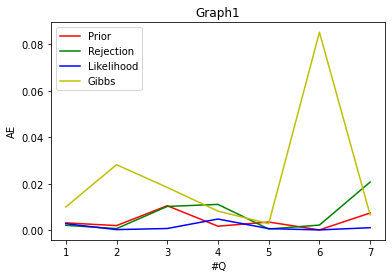

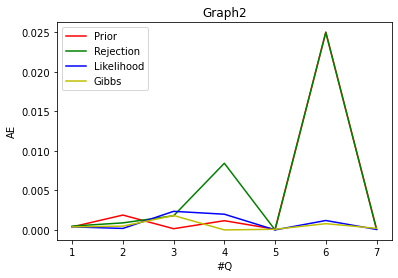

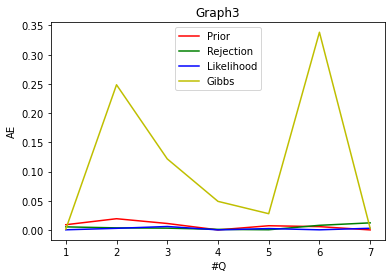

In [20]:
for o in range(1, length + 1): # 1 to 3 (lenght = 3)
    path = os.path.join(IN_PATH, str(o) + "\input.txt") # inputs\1\input.txt
    file = open(path, 'r')
    n = int(file.readline()) # num of nodes
    names = {} # names["A"] = 0
    probability = [] # array of CPTs (probability[0] = CPT of A) (all distributions)
    graph3 = [] # node --> parents (graph3[0] = ["B", "C"])
    graph2 = [] # node --> parents (graph2[0] = [1, 2])
    graph1 = [] # node --> children (graph1[0] = [1, 2])
    for i in range(n):
        graph1.append([])
        graph2.append([])
        graph3.append([])
    for i in range(n):
        data = file.readline()
        data = data.strip('\n') # remove
        data = data.rstrip() # "A"
        names[data] = i # names["A"] = 0
        data = file.readline()
        data = data.strip('\n')
        data = data.rstrip()
        if 47 < ord(data[0]) < 58: # if data[0] is a number
            cpt = []
            row = {i: True, 'Prob': float(data)} # {0: True, 'Prob': 0.2}
            cpt.append(row)
            row = {i: False, 'Prob': 1 - float(data)} # {0: False, 'Prob': 0.8}
            cpt.append(row) 
            probability.append(cpt) # probability[0] = [{0: True, 'Prob': 0.2}, {0: False, 'Prob': 0.8}]
        else: # if data[0] is a letter
            parents = [x for x in data.split(" ")] # ["B", "C"]
            for parent in parents:
                graph3[i].append(parent) # graph3[0] = ["B", "C"]
            cpt = []
            for j in range(2 ** (len(parents))): # 2 ** 2 = 4
                read = file.readline()
                read = read.strip('\n') # "0 0 0.999    \n"
                read = read.rstrip() # "0 0 0.999     "
                data = [float(x) for x in read.split(" ")] # [0, 0, 0.999]
                row = {i: True, 'Prob': data[len(data) - 1]}
                for k in range(len(parents)):
                    row[parents[k]] = bool(data[k]) # {0: True, 'Prob': 0.999, 'B': False, 'C': False}
                cpt.append(row) # cpt[0] = {0: True, 'Prob': 0.999, 'B': False, 'C': False}
                row2 = row.copy()
                row2[i] = False
                row2['Prob'] = 1 - row2["Prob"] # {0: False, 'Prob': 0.001, 'B': False, 'C': False}
                cpt.append(row2) # array of 8 rows(objects)
            probability.append(cpt) # probability[0] = [{0: True, 'Prob': 0.999, 'B': False, 'C': False}, {0: False, 'Prob': 0.001, 'B': False, 'C': False}, {0: True, 'Prob': 0.999, 'B': False, 'C': True}, {0: False, 'Prob': 0.001, 'B': False, 'C': True}, {0: True, 'Prob': 0.999, 'B': True, 'C': False}, {0: False, 'Prob': 0.001, 'B': True, 'C': False}, {0: True, 'Prob': 0.999, 'B': True, 'C': True}, {0: False, 'Prob': 0.001, 'B': True, 'C': True}]

    for i in range(n):
        for node in graph3[i]:  # node = "B" or "C" (parents) (graph3[0] = ["B", "C"])
            graph1[names[node]].append(i) # graph1[0] = [1, 2] (parent --> child)
            graph2[i].append(names[node]) # graph2[0] = [1, 2] (child --> parent)

    new_probability = [] 
    for cpt in probability: # cpt = probability[0] = [{0: True, 'Prob': 0.999, 'B': False, 'C': False}, {0: False, 'Prob': 0.001, 'B': False, 'C': False}, {0: True, 'Prob': 0.999, 'B': False, 'C': True}, {0: False, 'Prob': 0.001, 'B': False, 'C': True}, {0: True, 'Prob': 0.999, 'B': True, 'C': False}, {0: False, 'Prob': 0.001, 'B': True, 'C': False}, {0: True, 'Prob': 0.999, 'B': True, 'C': True}, {0: False, 'Prob': 0.001, 'B': True, 'C': True}]
        new_cpt = []
        for row in cpt: # (0 : "A") cpt[0] = row = {0: True, 'Prob': 0.999, 'B': False, 'C': False}
            new_row = {}
            for key in row.keys():
                if key in names.keys():
                    new_row[names[key]] = row[key]
                else:
                    new_row[key] = row[key]
            new_cpt.append(new_row) # {0: True, 'Prob': 0.999, 1: False, 2: False} = new_cpt[0] = new_row
        new_probability.append(new_cpt) # new_probability[0] = [{0: True, 'Prob': 0.999, 1: False, 2: False}, {0: False, 'Prob': 0.001, 1: False, 2: False}, {0: True, 'Prob': 0.999, 1: False, 2: True}, {0: False, 'Prob': 0.001, 1: False, 2: True}, {0: True, 'Prob': 0.999, 1: True, 2: False}, {0: False, 'Prob': 0.001, 1: True, 2: False}, {0: True, 'Prob': 0.999, 1: True, 2: True}, {0: False, 'Prob': 0.001, 1: True, 2: True}]

    file.close()

    path = os.path.join(IN_PATH, str(o) + "\q_input.txt")
    file = open(path, 'r')
    data = file.readline()
    x = json.loads(data) # [[{"A": 0 }, {}],[{"C": 1}, {"A":1 , "B": 1}]]

    result_string = ""

    prior = [] # array of absolute errors 
    reject = []
    likelihood = []
    gibbs = []

    for query in x: # query = [{"A": 0 }, {}] or [{"C": 1}, {"A":1 , "B": 1}]
        node_data = query[0] # node_data = {"A": 0} or {"C": 1}
        evidence_data = query[1] # evidence_data = {"A": 1, "B": 1}
        evidence = [-1] * n
        nodes = [] # nodes that we want to know the value of (query)
        values = [] # values of nodes that we want to know the value of (query value = 1 or 0)
        for key in evidence_data.keys():
            evidence[names[key]] = bool(evidence_data[key]) # evidence = [True, True, False] # evidence[0] = "A" = True
        for key in node_data.keys():
            nodes.append(names[key]) # nodes = [2] # nodes[0] = 2 (C)
            values.append(node_data[key]) # values = [1] # values[0] = 1 (True) (assume for C)

        # nodes -> query variable(s) P(query(nodes) | evidence)
        result_real = real_value(evidence, new_probability.copy(), nodes, values, graph2) # exact inference (real value)
        # approximate inferences
        result_prior_sample = prior_sample(evidence, nodes, values, new_probability, n, graph1, graph2) # prior sampling
        result_rejection_sample = rejection_sample(evidence, nodes, values, new_probability, n, graph1, graph2) # rejection sampling
        result_likelihood_sample = likelihood_sample(evidence, nodes, values, new_probability, n, graph1, graph2) # likelihood weighting
        result_gibbs_sample = gibbs_sample(evidence, nodes, values, new_probability, n, graph1, graph2) # gibbs sampling

        ae_prior = abs(result_prior_sample - result_real) # absolute error
        ae_rejection = abs(result_rejection_sample - result_real)
        ae_likelihood = abs(result_likelihood_sample - result_real)
        ae_gibbs = abs(result_gibbs_sample - result_real)

        result_string += str(result_real) + " " + str(ae_prior) + " " + str(ae_rejection) + " " + str(ae_likelihood) + " " + str(ae_gibbs) + "\n"

        prior.append(ae_prior)
        reject.append(ae_rejection)
        likelihood.append(ae_likelihood)
        gibbs.append(ae_gibbs)

    file.close()

    path = os.path.join(OUT_PATH, str(o) + ".txt")
    file = open(path, 'w')
    file.write(result_string)
    file.close()

    draw_plot(prior, reject, likelihood, gibbs, "Graph" + str(o), o)